# Axona to NWB

Convert Axona raw (`.bin` + `.set`) or unit data (`.X`, `.pos`, `.eeg`, `.egf`) to NWB format. 

It might be handy to convert the position data in the `.bin` file to a `.pos` file, allowing us to use the same code for both axona formats, as well as the Intan format later on (requiring the Hussaini lab to create their own `.pos` files based on the position tracking used). 

### Axona raw (`.bin` + `.set`)

In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import os
from pathlib import Path

# Old .bin file
base_dir = Path('/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/')
dir_name = base_dir / 'example_data_raw'
base_filename = '20201004_Raw'

# New .bin file
base_dir = Path('/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/new_session_data')
dir_name = base_dir / '06172021-HPC-B6-RAW'
base_filename = '06172021-HPC-B6-RAW'
filename = os.path.join(dir_name, base_filename)
set_file = filename + '.set'
bin_file = filename + '.bin'
print(filename)

/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/new_session_data/06172021-HPC-B6-RAW/06172021-HPC-B6-RAW


In [3]:
from nwb_conversion_tools import (
    NWBConverter, AxonaRecordingExtractorInterface, AxonaPositionDataInterface
)

In [4]:
class HussainiAxonaNWBConverter(NWBConverter):
    data_interface_classes = dict(
        AxonaRecordingExtractorInterface=AxonaRecordingExtractorInterface,
        AxonaPositionDataInterface=AxonaPositionDataInterface
    )

In [5]:
import random
import string
from typing import Union, Optional
from pathlib import Path
import spikeextractors as se
from pynwb import NWBFile
import numpy as np
import re
import datetime
import json
from jsonschema import validate, ValidationError

from nwb_conversion_tools.utils.json_schema import get_schema_from_method_signature, get_base_schema, fill_defaults
from nwb_conversion_tools import SpikeGLXRecordingInterface

In [6]:
# Specify source data

source_data = dict(
    AxonaPositionDataInterface=dict(
        filename=set_file
    ),
    AxonaRecordingExtractorInterface=dict(
        filename=set_file
    )
)
print(json.dumps(source_data, indent=2))

{
  "AxonaPositionDataInterface": {
    "filename": "/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/new_session_data/06172021-HPC-B6-RAW/06172021-HPC-B6-RAW.set"
  },
  "AxonaRecordingExtractorInterface": {
    "filename": "/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/new_session_data/06172021-HPC-B6-RAW/06172021-HPC-B6-RAW.set"
  }
}


In [7]:
# Initialize HussainiAxonaNWBConverter

converter = HussainiAxonaNWBConverter(source_data=source_data)

Source data is valid!


In [8]:
# Get metadata

metadata = converter.get_metadata()
metadata

{'NWBFile': {'session_description': '',
  'session_start_time': '2021-06-17T12:22:02',
  'identifier': '2501b0ed-db4b-4e1c-8591-e1d0ae82a492',
  'experimenter': ['Abid']},
 'Ecephys': {'Device': [{'name': 'Axona',
    'description': 'Axona DacqUSB, sw_version=1.2.2.16',
    'manufacturer': 'Axona'}],
  'ElectrodeGroup': [{'name': 'Group0',
    'location': '',
    'device': 'Axona',
    'description': 'Group 0 electrodes.'},
   {'name': 'Group1',
    'location': '',
    'device': 'Axona',
    'description': 'Group 1 electrodes.'},
   {'name': 'Group2',
    'location': '',
    'device': 'Axona',
    'description': 'Group 2 electrodes.'},
   {'name': 'Group3',
    'location': '',
    'device': 'Axona',
    'description': 'Group 3 electrodes.'}],
  'Electrodes': [{'name': 'group_name',
    'description': 'The name of the ElectrodeGroup this electrode is a part of.'}],
  'ElectricalSeries_raw': {'name': 'ElectricalSeries_raw',
   'description': 'Raw acquisition traces.'}}}

In [9]:
# Get metadata_schema from converter

metadata_schema = converter.get_metadata_schema()

print(json.dumps(metadata_schema['properties'], indent=2))

{
  "NWBFile": {
    "required": [
      "session_description",
      "identifier",
      "session_start_time"
    ],
    "properties": {
      "session_description": {
        "type": "string",
        "format": "long",
        "description": "a description of the session where this data was generated",
        "default": ""
      },
      "identifier": {
        "type": "string",
        "description": "a unique text identifier for the file",
        "default": "0d17a802-0d42-49ef-9a3e-a707ee2549df"
      },
      "session_start_time": {
        "type": "string",
        "description": "the start date and time of the recording session",
        "format": "date-time",
        "default": "2021-06-17T12:22:02"
      },
      "experimenter": {
        "type": "array",
        "items": {
          "type": "string",
          "title": "experimenter"
        },
        "description": "name of person who performed experiment",
        "default": [
          "Abid"
        ]
      },
      "e

In [10]:
# Validate metadata against metadata_schema

validate(
    instance=converter.get_metadata(),
    schema=converter.get_metadata_schema()
)

In [11]:
converter.get_metadata()

{'NWBFile': {'session_description': '',
  'session_start_time': '2021-06-17T12:22:02',
  'identifier': '81dbc131-88da-4b1b-95ab-7c49e5fdffd2',
  'experimenter': ['Abid']},
 'Ecephys': {'Device': [{'name': 'Axona',
    'description': 'Axona DacqUSB, sw_version=1.2.2.16',
    'manufacturer': 'Axona'}],
  'ElectrodeGroup': [{'name': 'Group0',
    'location': '',
    'device': 'Axona',
    'description': 'Group 0 electrodes.'},
   {'name': 'Group1',
    'location': '',
    'device': 'Axona',
    'description': 'Group 1 electrodes.'},
   {'name': 'Group2',
    'location': '',
    'device': 'Axona',
    'description': 'Group 2 electrodes.'},
   {'name': 'Group3',
    'location': '',
    'device': 'Axona',
    'description': 'Group 3 electrodes.'}],
  'Electrodes': [{'name': 'group_name',
    'description': 'The name of the ElectrodeGroup this electrode is a part of.'}],
  'ElectricalSeries_raw': {'name': 'ElectricalSeries_raw',
   'description': 'Raw acquisition traces.'}}}

In [12]:
from nwb_conversion_tools.utils.conversion_tools import (
    get_default_nwbfile_metadata, make_nwbfile_from_metadata
)

In [13]:
metadata

{'NWBFile': {'session_description': '',
  'session_start_time': '2021-06-17T12:22:02',
  'identifier': '2501b0ed-db4b-4e1c-8591-e1d0ae82a492',
  'experimenter': ['Abid']},
 'Ecephys': {'Device': [{'name': 'Axona',
    'description': 'Axona DacqUSB, sw_version=1.2.2.16',
    'manufacturer': 'Axona'}],
  'ElectrodeGroup': [{'name': 'Group0',
    'location': '',
    'device': 'Axona',
    'description': 'Group 0 electrodes.'},
   {'name': 'Group1',
    'location': '',
    'device': 'Axona',
    'description': 'Group 1 electrodes.'},
   {'name': 'Group2',
    'location': '',
    'device': 'Axona',
    'description': 'Group 2 electrodes.'},
   {'name': 'Group3',
    'location': '',
    'device': 'Axona',
    'description': 'Group 3 electrodes.'}],
  'Electrodes': [{'name': 'group_name',
    'description': 'The name of the ElectrodeGroup this electrode is a part of.'}],
  'ElectricalSeries_raw': {'name': 'ElectricalSeries_raw',
   'description': 'Raw acquisition traces.'}}}

In [14]:
output_file = base_dir / 'out_example.nwb'

In [100]:
# Export to NWB file

output_file = base_dir / 'out_example.nwb'

converter.run_conversion(
    metadata=metadata, 
    nwbfile_path=output_file,
    overwrite=True,
    save_to_file=True,
    conversion_options=None
)

Metadata is valid!


/home/sbuergers/spikeinterface/hussaini-test-pipeline/venv/lib/python3.8/site-packages/pynwb/file.py:801: UserWarning: Date is missing timezone information. Updating to local timezone.
  warn("Date is missing timezone information. Updating to local timezone.")
/home/sbuergers/spikeinterface/hussaini-test-pipeline/venv/lib/python3.8/site-packages/hdmf/common/table.py:447: UserWarning: An attribute 'name' already exists on DynamicTable 'electrodes' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using other methods, e.g., table['name'].
  warn(msg)
/home/sbuergers/spikeinterface/hussaini-test-pipeline/venv/lib/python3.8/site-packages/hdmf/build/objectmapper.py:256: DtypeConversionWarning: Spec 'SpatialSeries/timestamps': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)


NWB file saved at /mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/new_session_data/out_example.nwb!


In [15]:
# Check NWB file

from pynwb import NWBHDF5IO

fname = output_file
with NWBHDF5IO(fname, 'r') as io:
    nwbfile = io.read()
    print(nwbfile)

root pynwb.file.NWBFile at 0x140690704186384
Fields:
  acquisition: {
    ElectricalSeries_raw <class 'pynwb.ecephys.ElectricalSeries'>
  }
  devices: {
    Axona <class 'pynwb.device.Device'>
  }
  electrode_groups: {
    Group0 <class 'pynwb.ecephys.ElectrodeGroup'>,
    Group1 <class 'pynwb.ecephys.ElectrodeGroup'>,
    Group2 <class 'pynwb.ecephys.ElectrodeGroup'>,
    Group3 <class 'pynwb.ecephys.ElectrodeGroup'>
  }
  electrodes: electrodes <class 'hdmf.common.table.DynamicTable'>
  experimenter: ['Abid']
  file_create_date: [datetime.datetime(2021, 7, 27, 18, 15, 39, 384626, tzinfo=tzoffset(None, 7200))]
  identifier: 6ff7dabe-ed6d-45aa-b966-635423873bf1
  processing: {
    behavior <class 'pynwb.base.ProcessingModule'>
  }
  session_start_time: 2021-06-17 12:22:02+02:00
  timestamps_reference_time: 2021-06-17 12:22:02+02:00



/home/sbuergers/spikeinterface/hussaini-test-pipeline/venv/lib/python3.8/site-packages/hdmf/common/table.py:447: UserWarning: An attribute 'name' already exists on DynamicTable 'electrodes' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using other methods, e.g., table['name'].
  warn(msg)


In [16]:
%matplotlib inline
import matplotlib.pyplot as plt


from nwbwidgets import nwb2widget

output_file = '/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/sample_bin_to_tint/nwb/axona_se_MS4.nwb'
#output_file = '/mnt/d/NWB/data/NWBData/NWBData/P9HMH_NOID5.nwb'

io = NWBHDF5IO(output_file, mode='r')
nwb = io.read()

nwb2widget(nwb)

In [17]:
from nwb_conversion_tools.datainterfaces.ecephys.axona.axonadatainterface import get_position_object

pos = get_position_object(filename=set_file)

In [18]:
nwb.processing['behavior'].data_interfaces['Position'].spatial_series['t'].data

KeyError: 'behavior'

In [ ]:
pos.spatial_series['t'].timestamps

### Parse `.pos` files

In [128]:
from nwb_conversion_tools.datainterfaces.ecephys.axona.axonadatainterface import parse_generic_header

# Old pos file
pos_file = '/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/sample_bin_to_tint/axona_sample.pos'

# New pos file
pos_file = '/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/new_session_data/06172021-HPC-B6-UNIT/06172021-HPC-B6-UNIT/06172021-B6-HPC-UNIT.pos'
print(pos_file)

pos_header = parse_generic_header(pos_file, None)
pos_header

/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/new_session_data/06172021-HPC-B6-UNIT/06172021-HPC-B6-UNIT/06172021-B6-HPC-UNIT.pos


{'trial_date': 'Thursday, 17 Jun 2021',
 'trial_time': '12:22:02',
 'experimenter': 'Abid',
 'comments': '',
 'duration': '301',
 'sw_version': '1.2.2.16',
 'num_colours': '4',
 'min_x': '0',
 'max_x': '640',
 'min_y': '0',
 'max_y': '480',
 'window_min_x': '247',
 'window_max_x': '426',
 'window_min_y': '179',
 'window_max_y': '357',
 'timebase': '50 hz',
 'bytes_per_timestamp': '4',
 'sample_rate': '50.0 hz',
 'EEG_samples_per_position': '5',
 'bearing_colour_1': '0',
 'bearing_colour_2': '0',
 'bearing_colour_3': '0',
 'bearing_colour_4': '0',
 'pos_format': 't,x1,y1,x2,y2,numpix1,numpix2',
 'bytes_per_coord': '2',
 'pixels_per_metre': '300',
 'num_pos_samples': '15050'}

Data (with memory map)

In [129]:
def get_header_bstring(file):
    """
    Scan file for the occurrence of 'data_start' and return the header
    as byte string

    Parameters
    ----------
    file (str or path): file to be loaded

    Returns
    -------
    str: header byte content
    """

    header = b''
    with open(file, 'rb') as f:
        for bin_line in f:
            if b'data_start' in bin_line:
                header += b'data_start'
                break
            else:
                header += bin_line
    return header

In [130]:
with open(pos_file, 'rb') as f:
    print(f.read(532))
    print(f.read(1))

b'trial_date Thursday, 17 Jun 2021\r\ntrial_time 12:22:02\r\nexperimenter Abid\r\ncomments \r\nduration 301       \r\nsw_version 1.2.2.16\r\nnum_colours 4\r\nmin_x 0\r\nmax_x 640\r\nmin_y 0\r\nmax_y 480\r\nwindow_min_x 247\r\nwindow_max_x 426\r\nwindow_min_y 179\r\nwindow_max_y 357\r\ntimebase 50 hz\r\nbytes_per_timestamp 4\r\nsample_rate 50.0 hz\r\nEEG_samples_per_position 5\r\nbearing_colour_1 0\r\nbearing_colour_2 0\r\nbearing_colour_3 0\r\nbearing_colour_4 0\r\npos_format t,x1,y1,x2,y2,numpix1,numpix2\r\nbytes_per_coord 2\r\npixels_per_metre 300\r\nnum_pos_samples 15050     \r'
b'\n'


### LFP data

First, let's look at the tools from the Hussaini lab. And let's also remind ourselves what the file formats of .eeg and .egf data should look like:

```
EEG data is usually recorded continuously at 250 Hz in unit recording mode. The “.eeg” and “.eg2” files contain the data from the primary and secondary EEG channels, if these have been enabled. Very simply, the data consist of “num_EEG_samples” data bytes, following on from the data_start. The sample count is specified in the header. The “.egf” file is stored if a user selects a higher-sample rate EEG. Samples are normally collected at 4800 Hz (specified in the header), and are also normally 2 bytes long, rather than just 1.
```

In [17]:
# Hussaini lab tools: https://github.com/HussainiLab/BinConverter/blob/master/BinConverter/core/CreateEEG.py

from BinConverter.core.CreateEEG import (
    fir_hann, fir_hann, EEG_downsample, create_egf, write_eeg
)

Try using a NumpyRecordingExtractor to ingest '.eeg' or '.egf' data.
The user can ultimately specify whether to use .eeg or .egf data to be saved as LFP data in the nwb file. By default we
will prefer .eeg data, since it has a lower sampling rate and is more memory efficient. In most cases researchers will
not want to look at high frequency oscillations in LFP data.

We can first extract the data of interest as a numpy ndarray, then create a NumpyRecordingExtractor for the nwb conversion.


*  Case 1: Extract numpy ndarray from `.bin` data (very high Fs)

In [309]:
recording = se.AxonaRecordingExtractor(filename=set_file)

In [301]:
recording_filt.get_traces(start_frame=0, end_frame=100, return_scaled=False)

array([[ -110.86626 ,  -122.72912 ,  -135.46753 , ..., -1459.9774  ,
        -1509.474   , -1549.5364  ],
       [  504.85666 ,   546.55194 ,   584.92737 , ..., -1228.8933  ,
        -1313.7294  , -1388.8539  ],
       [ -146.00822 ,  -152.26958 ,  -156.87923 , ..., -1237.9406  ,
        -1245.1113  , -1244.1323  ],
       ...,
       [  264.44162 ,   294.47678 ,   326.27042 , ...,   418.20773 ,
          368.78357 ,   309.49866 ],
       [  -19.883978,   -19.218447,   -17.474897, ...,  2162.0952  ,
         2194.8843  ,  2212.9387  ],
       [  134.83208 ,   143.15527 ,   150.35118 , ..., -1794.1885  ,
        -1710.0737  , -1612.1694  ]], dtype=float32)

In [303]:
st.preprocessing.bandpass_filter??

In [317]:
gains

array([[0.00114441],
       [0.00114441],
       [0.00114441],
       [0.00114441],
       [0.00114441],
       [0.00114441],
       [0.00114441],
       [0.00114441],
       [0.00114441],
       [0.00114441],
       [0.00114441],
       [0.00114441],
       [0.00114441],
       [0.00114441],
       [0.00114441],
       [0.00114441]])

In [321]:
not_scaled = 100
gain = 1.25
offset = 10
scaled = not_scaled * gain + offset

print(scaled)

unscaled = (scaled - offset) / gain

print(unscaled)

135.0
100.0


In [325]:
recording_filt.get_channel_gains()

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
scaled = not_scaled * gain + offset

non_scales = (scaled - offset) / gain

In [312]:
# scaling
channel_ids = recording.get_channel_ids()
traces = recording.get_traces(start_frame=0, end_frame=100, return_scaled=False)

channel_idxs = np.array([recording.get_channel_ids().index(ch) for ch in channel_ids])
gains = recording.get_channel_gains()[channel_idxs, None]
offsets = recording.get_channel_offsets()[channel_idxs, None]
unscaled = (scaled - offset) / gain

traces = (traces.astype("float32") * gains + offsets).astype("float32")

In [313]:
recording.get_traces(start_frame=0, end_frame=100, return_scaled=False)

array([[   776,  11836,   2654, ...,  -7130,  -7420,  -6984],
       [ -3108,   6930,  -2686, ...,  -8120, -15106, -15106],
       [ -8126,   3032,   5224, ...,  -7418,  -9540, -10140],
       ...,
       [ -2998,  -2500,   -908, ...,   1540,     32,   -624],
       [  3430,   -832,   3690, ...,   4788,   3974,   3870],
       [  2376,   4430,   4290, ...,  -4968,  -6388,  -7966]], dtype=int16)

In [314]:
traces

array([[  0.8880615 ,  13.545227  ,   3.037262  , ...,  -8.159637  ,
         -8.491516  ,  -7.9925537 ],
       [ -3.5568237 ,   7.9307556 ,  -3.073883  , ...,  -9.292603  ,
        -17.287445  , -17.287445  ],
       [ -9.299469  ,   3.4698486 ,   5.9783936 , ...,  -8.489227  ,
        -10.917664  , -11.604309  ],
       ...,
       [ -3.4309387 ,  -2.861023  ,  -1.0391235 , ...,   1.7623901 ,
          0.03662109,  -0.7141113 ],
       [  3.9253235 ,  -0.95214844,   4.22287   , ...,   5.479431  ,
          4.547882  ,   4.4288635 ],
       [  2.7191162 ,   5.0697327 ,   4.9095154 , ...,  -5.685425  ,
         -7.310486  ,  -9.116364  ]], dtype=float32)

In [326]:
se.CacheRecordingExtractor??

In [ ]:
# Filter the data to avoid aliasing based on desired sampling frequency. The nyquest theorem states we need 
# twice the sampling rate of the highest frequency we are interested in. Conversely, we want to filter out all frequencies
# higher than half our sampling rate. Since filters are not perfect and have a certain transition width until full
# attenuation, we are conservative and choose sampling_rate / 2.25 as our cut-off high frequency threshold.

import spiketoolkit as st

sampling_rate = 250  # .eeg=250, .egf=4800

recording_filt = st.preprocessing.bandpass_filter(recording, freq_min=0, freq_max=np.floor(sampling_rate / 2.25))

#recording_downsamp = st.preprocessing.ResampleRecording(recording_filt, sampling_rate)

channel_ids = recording.get_channel_ids()
channel_idxs = np.array([recording.get_channel_ids().index(ch) for ch in channel_ids])
gains = recording.get_channel_gains()[channel_idxs, None]
offsets = recording.get_channel_offsets()[channel_idxs, None]
unscaled = (recording_filt.get_traces() - offsets) / gains

traces = (traces.astype("float32") * gains + offsets).astype("float32")

In [266]:
# Filter the data to avoid aliasing based on desired sampling frequency. The nyquest theorem states we need 
# twice the sampling rate of the highest frequency we are interested in. Conversely, we want to filter out all frequencies
# higher than half our sampling rate. Since filters are not perfect and have a certain transition width until full
# attenuation, we are conservative and choose sampling_rate / 2.25 as our cut-off high frequency threshold.

import spiketoolkit as st

sampling_rate = 250  # .eeg=250, .egf=4800

recording_filt = st.preprocessing.bandpass_filter(recording, freq_min=0, freq_max=np.floor(sampling_rate / 2.25))

recording_downsamp = st.preprocessing.ResampleRecording(recording_filt, sampling_rate)

In [152]:
perma_cache_filename = os.path.join(dir_name, 'cached_data_eeg.dat') 
recording_cache = se.CacheRecordingExtractor(recording_filt, save_path = perma_cache_filename)
recording_cache.dump_to_pickle(os.path.join(dir_name, 'cached_data_eeg.pkl'))

In [ ]:
recording_cache = se.load_extractor_from_pickle(os.path.join(dir_name, 'cached_data_eeg.pkl'))

In [153]:
type(recording_cache)

spikeextractors.cacheextractors.CacheRecordingExtractor

*  Case 2: Extract numpy ndarray from `.eeg` data (low Fs)

In [150]:
type(recording)

spikeextractors.extractors.neoextractors.axonaextractor.AxonaRecordingExtractor

In [149]:
type(recording_filt)

spiketoolkit.preprocessing.bandpass_filter.BandpassFilterRecording

*  Case 3: Extract numpy ndarray from `.egf` data (high Fs)

In [23]:

RX = se.NumpyRecordingExtractor()

RX

Exception ignored in: <function BaseExtractor.__del__ at 0x7fc18fedd9d0>
Traceback (most recent call last):
  File "/home/sbuergers/spikeinterface/hussaini-test-pipeline/venv/lib/python3.8/site-packages/spikeextractors/baseextractor.py", line 36, in __del__
    for memmap_obj in self._memmap_files:
AttributeError: 'NumpyRecordingExtractor' object has no attribute '_memmap_files'


TypeError: __init__() missing 2 required positional arguments: 'timeseries' and 'sampling_frequency'

In [348]:
se.CacheRecordingExtractor??

In [340]:
from nwb_conversion_tools.datainterfaces.ecephys.baselfpextractorinterface import BaseLFPExtractorInterface
from nwb_conversion_tools.datainterfaces.ecephys.axona.axonadatainterface import AxonaRecordingExtractorInterface
from nwb_conversion_tools.utils.json_schema import get_schema_from_hdmf_class
from nwb_conversion_tools.utils.spike_interface import write_recording
from pynwb.ecephys import ElectricalSeries
import spiketoolkit as st


OptionalPathType = Optional[Union[str, Path]]


class AxonaLFPExtractorInterface(AxonaRecordingExtractorInterface):
    """..."""
    
    def __init__(self, filename: str):
        super().__init__(filename=filename)
        sampling_rate = 250  # .eeg=250, .egf=4800
        print('Filtering and caching, this may take a few minutes ...')
        recording_filt = st.preprocessing.bandpass_filter(
            self.RX(filename=filename),
            freq_min=0,
            freq_max=np.floor(sampling_rate / 2.25)
        )
        recording_downsamp = st.preprocessing.ResampleRecording(recording_filt, sampling_rate)
        self.recording_extractor = se.CacheRecordingExtractor(
            recording_downsamp,
            return_scaled=False,
            dtype=np.int16
        )
        self.subset_channels = None
        
    def get_metadata_schema(self):
        metadata_schema = super().get_metadata_schema()
        metadata_schema["properties"]["Ecephys"]["properties"].update(
            ElectricalSeries_lfp=get_schema_from_hdmf_class(ElectricalSeries)
        )
        return metadata_schema

    def get_metadata(self):
        """Retrieve Ecephys metadata specific to the Axona format."""
        metadata = super().get_metadata()
        metadata['Ecephys'].pop('ElectricalSeries_raw', None)
        metadata['Ecephys'].update(
            ElectricalSeries_lfp=dict(
                name="LFP",
                description="Local field potential signal."
            )
        )

        return metadata
    
    def run_conversion(
        self,
        nwbfile: NWBFile,
        metadata: dict = None,
        stub_test: bool = False,
        use_times: bool = False,
        save_path: OptionalPathType = None,
        overwrite: bool = False,
        buffer_mb: int = 500
    ):
        """
        Primary function for converting low-pass recording extractor data to nwb.

        Parameters
        ----------
        nwbfile: NWBFile
            nwb file to which the recording information is to be added
        metadata: dict
            metadata info for constructing the nwb file (optional).
            Should be of the format
                metadata['Ecephys']['ElectricalSeries'] = dict(name=my_name, description=my_description)
        use_times: bool
            If True, the times are saved to the nwb file using recording.frame_to_time(). If False (default),
            the sampling rate is used.
        save_path: PathType
            Required if an nwbfile is not passed. Must be the path to the nwbfile
            being appended, otherwise one is created and written.
        overwrite: bool
            If using save_path, whether or not to overwrite the NWBFile if it already exists.
        stub_test: bool, optional (default False)
            If True, will truncate the data to run the conversion faster and take up less memory.
        buffer_mb: int (optional, defaults to 500MB)
            Maximum amount of memory (in MB) to use per iteration of the internal DataChunkIterator.
            Requires trace data in the RecordingExtractor to be a memmap object.
        """
        if stub_test or self.subset_channels is not None:
            recording = self.subset_recording(stub_test=stub_test)
        else:
            recording = self.recording_extractor
        write_recording(
            recording=recording,
            nwbfile=nwbfile,
            metadata=metadata,
            use_times=use_times,
            write_as="lfp",
            es_key="ElectricalSeries_lfp",
            save_path=save_path,
            overwrite=overwrite,
            buffer_mb=buffer_mb
        )

In [341]:
set_filename = '/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/new_session_data/06172021-HPC-B6-RAW/06172021-HPC-B6-RAW.set'

In [342]:
axo_raw = AxonaRecordingExtractorInterface(filename=set_filename)

print(axo_raw.recording_extractor.get_shared_channel_property_names())

axo_raw.get_metadata()
axo_raw.recording_extractor.get_shared_channel_property_names()

['gain', 'group', 'name', 'offset']


['gain', 'group', 'group_name', 'name', 'offset']

In [343]:
axo_lfp.source_data

{'filename': '/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/new_session_data/06172021-HPC-B6-RAW/06172021-HPC-B6-RAW.set'}

In [344]:
axo_lfp = AxonaLFPExtractorInterface(filename=set_filename)

print(axo_lfp.recording_extractor.get_shared_channel_property_names())

axo_lfp.get_metadata()
axo_lfp.recording_extractor.get_shared_channel_property_names()

Exception ignored in: <function CacheRecordingExtractor.__del__ at 0x7ff5ce4b68b0>
Traceback (most recent call last):
  File "/home/sbuergers/spikeinterface/hussaini-test-pipeline/venv/lib/python3.8/site-packages/spikeextractors/cacheextractors.py", line 57, in __del__
    if self._is_tmp:
AttributeError: 'CacheRecordingExtractor' object has no attribute '_is_tmp'


Filtering and caching, this may take a few minutes ...


TypeError: __init__() got an unexpected keyword argument 'dtype'

In [345]:
axo_lfp.get_source_schema()

{'required': ['filename'],
 'properties': {'filename': {'type': 'string'}},
 'type': 'object',
 'additionalProperties': False}

In [346]:
axo_lfp.get_conversion_options()

{}

In [244]:
axo_lfp.get_conversion_options_schema()

{'required': [],
 'properties': {'stub_test': {'type': 'boolean', 'default': False},
  'use_times': {'type': 'boolean', 'default': False},
  'save_path': {'type': 'string'},
  'overwrite': {'type': 'boolean', 'default': False},
  'buffer_mb': {'type': 'number', 'default': 500}},
 'type': 'object',
 'additionalProperties': False}

In [245]:
axo_lfp.run_conversion?

In [159]:
metadata = axo_lfp.get_metadata()

metadata

{'Ecephys': {'Device': [{'name': 'Axona',
    'description': 'Axona DacqUSB, sw_version=1.2.2.16',
    'manufacturer': 'Axona'}],
  'ElectrodeGroup': [{'name': 'Group0',
    'location': '',
    'device': 'Axona',
    'description': 'Group 0 electrodes.'},
   {'name': 'Group1',
    'location': '',
    'device': 'Axona',
    'description': 'Group 1 electrodes.'},
   {'name': 'Group2',
    'location': '',
    'device': 'Axona',
    'description': 'Group 2 electrodes.'},
   {'name': 'Group3',
    'location': '',
    'device': 'Axona',
    'description': 'Group 3 electrodes.'}],
  'Electrodes': [{'name': 'group_name',
    'description': 'The name of the ElectrodeGroup this electrode is a part of.'}],
  'ElectricalSeries_lfp': {'name': 'LFP',
   'description': 'Local field potential signal.'}},
 'NWBFile': {'session_start_time': '2021-06-17T12:22:02',
  'session_description': '',
  'experimenter': ['Abid']}}

In [91]:
import uuid
from datetime import datetime
import warnings
import numpy as np
import distutils.version
from pathlib import Path
from typing import Union, Optional, List
from warnings import warn
import psutil
from collections import defaultdict

import spikeextractors as se
import pynwb
from numbers import Real
from hdmf.data_utils import DataChunkIterator
from hdmf.backends.hdf5.h5_utils import H5DataIO
#from .json_schema import dict_deep_update

PathType = Union[str, Path, None]
ArrayType = Union[list, np.ndarray]

In [92]:
nwbfile

root pynwb.file.NWBFile at 0x140690625870624
Fields:
  devices: {
    Axona <class 'pynwb.device.Device'>
  }
  electrode_groups: {
    Group0 <class 'pynwb.ecephys.ElectrodeGroup'>,
    Group1 <class 'pynwb.ecephys.ElectrodeGroup'>,
    Group2 <class 'pynwb.ecephys.ElectrodeGroup'>,
    Group3 <class 'pynwb.ecephys.ElectrodeGroup'>
  }
  experimenter: ['Abid']
  file_create_date: [datetime.datetime(2021, 7, 29, 10, 56, 37, 843939, tzinfo=tzlocal())]
  identifier: 332e3cde-bb07-4db4-859c-1c0cd8e697d4
  session_start_time: 2021-06-17 12:22:02+02:00
  timestamps_reference_time: 2021-06-17 12:22:02+02:00

In [160]:
class HussainiAxonaNWBConverter(NWBConverter):
    data_interface_classes = dict(
        AxonaRecordingExtractorInterface=AxonaRecordingExtractorInterface,
        AxonaPositionDataInterface=AxonaPositionDataInterface,
        AxonaLFPExtractorInterface=AxonaLFPExtractorInterface
    )
    
# Specify source data
source_data = dict(
#    AxonaPositionDataInterface=dict(
#        filename=set_file
#    ),
#    AxonaRecordingExtractorInterface=dict(
#        filename=set_file
#    ),
    AxonaLFPExtractorInterface=dict(
        filename=set_file
    )
)
print(json.dumps(source_data, indent=2))

# Initialize HussainiAxonaNWBConverter
converter = HussainiAxonaNWBConverter(source_data=source_data)

# Get metadata
metadata = converter.get_metadata()

# Validate metadata against metadata_schema
validate(
    instance=converter.get_metadata(),
    schema=converter.get_metadata_schema()
)

{
  "AxonaLFPExtractorInterface": {
    "filename": "/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/new_session_data/06172021-HPC-B6-RAW/06172021-HPC-B6-RAW.set"
  }
}
Source data is valid!


In [347]:
class HussainiAxonaNWBConverter(NWBConverter):
    data_interface_classes = dict(
        AxonaRecordingExtractorInterface=AxonaRecordingExtractorInterface,
        AxonaPositionDataInterface=AxonaPositionDataInterface,
        AxonaLFPExtractorInterface=AxonaLFPExtractorInterface
    )
    
# Specify source data
source_data = dict(
    AxonaPositionDataInterface=dict(
        filename=set_file
    ),
    AxonaRecordingExtractorInterface=dict(
        filename=set_file
    ),
    AxonaLFPExtractorInterface=dict(
        filename=set_file
    )
)
print(json.dumps(source_data, indent=2))

# Initialize HussainiAxonaNWBConverter
converter = HussainiAxonaNWBConverter(source_data=source_data)

# Get metadata
metadata = converter.get_metadata()

# Validate metadata against metadata_schema
validate(
    instance=converter.get_metadata(),
    schema=converter.get_metadata_schema()
)

# Export to NWB file
output_file = base_dir / 'out_example_test5.nwb'

converter.run_conversion(
    metadata=metadata, 
    nwbfile_path=output_file,
    overwrite=True,
    save_to_file=True,
    conversion_options=None
)

Exception ignored in: <function CacheRecordingExtractor.__del__ at 0x7ff5ce4b68b0>
Traceback (most recent call last):
  File "/home/sbuergers/spikeinterface/hussaini-test-pipeline/venv/lib/python3.8/site-packages/spikeextractors/cacheextractors.py", line 57, in __del__
    if self._is_tmp:
AttributeError: 'CacheRecordingExtractor' object has no attribute '_is_tmp'


{
  "AxonaPositionDataInterface": {
    "filename": "/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/new_session_data/06172021-HPC-B6-RAW/06172021-HPC-B6-RAW.set"
  },
  "AxonaRecordingExtractorInterface": {
    "filename": "/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/new_session_data/06172021-HPC-B6-RAW/06172021-HPC-B6-RAW.set"
  },
  "AxonaLFPExtractorInterface": {
    "filename": "/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/new_session_data/06172021-HPC-B6-RAW/06172021-HPC-B6-RAW.set"
  }
}
Source data is valid!
Filtering and caching, this may take a few minutes ...


TypeError: __init__() got an unexpected keyword argument 'dtype'

In [333]:
# Read data from the nwb file to see if we converted everything correctly

io = NWBHDF5IO(output_file, 'r')
nwbfile_in = io.read()

In [334]:
nwbfile_in.acquisition['ElectricalSeries_raw'].data

<HDF5 dataset "data": shape (14438700, 16), type "<i2">

In [335]:
nwbfile_in.processing['ecephys'].data_interfaces['LFP'].electrical_series['LFP'].data

<HDF5 dataset "data": shape (75201, 16), type "<f4">

In [336]:
np.arange(0,100)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

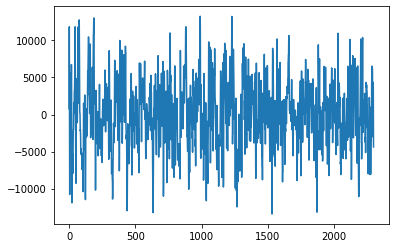

In [337]:
plt.plot(nwbfile_in.acquisition['ElectricalSeries_raw'].data[0:2300, 0])

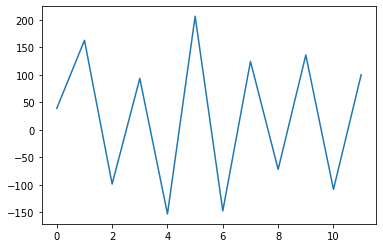

In [338]:
plt.plot(nwbfile_in.processing['ecephys'].data_interfaces['LFP'].electrical_series['LFP'].data[0:12, 0])

In [ ]:
test_timeseries_in = nwbfile_in.processing['test_timeseries']
print(test_timeseries_in)

In [97]:
axo_raw = AxonaRecordingExtractorInterface(filename=set_file)

In [102]:
nwbfile = generate_nwb

root pynwb.file.NWBFile at 0x140690625870624
Fields:
  devices: {
    Axona <class 'pynwb.device.Device'>
  }
  electrode_groups: {
    Group0 <class 'pynwb.ecephys.ElectrodeGroup'>,
    Group1 <class 'pynwb.ecephys.ElectrodeGroup'>,
    Group2 <class 'pynwb.ecephys.ElectrodeGroup'>,
    Group3 <class 'pynwb.ecephys.ElectrodeGroup'>
  }
  experimenter: ['Abid']
  file_create_date: [datetime.datetime(2021, 7, 29, 10, 56, 37, 843939, tzinfo=tzlocal())]
  identifier: 332e3cde-bb07-4db4-859c-1c0cd8e697d4
  session_start_time: 2021-06-17 12:22:02+02:00
  timestamps_reference_time: 2021-06-17 12:22:02+02:00

In [141]:
metadata = axo_raw.get_metadata()

axo_raw.run_conversion(
    nwbfile=make_nwbfile_from_metadata(metadata),
    metadata=metadata,
    overwrite=True,
    write_as='raw'
)

In [215]:
metadata = axo_lfp.get_metadata()

axo_lfp.run_conversion(
    nwbfile=make_nwbfile_from_metadata(metadata),
    metadata=metadata,
    overwrite=True,
    write_as='lfp'
)

In [136]:
axo_raw.run_conversion??

In [216]:
# Export to NWB file
output_file = base_dir / 'out_example_lfp.nwb'

converter.run_conversion(
    metadata=metadata, 
    nwbfile_path=output_file,
    overwrite=True,
    save_to_file=True,
    conversion_options=None
)

ValidationError: 'identifier' is a required property

Failed validating 'required' in schema['properties']['NWBFile']:
    {'additionalProperties': False,
     'properties': {'data_collection': {'description': 'Notes about data '
                                                       'collection and '
                                                       'analysis.',
                                        'type': 'string'},
                    'experiment_description': {'description': 'general '
                                                              'description '
                                                              'of the '
                                                              'experiment',
                                               'type': 'string'},
                    'experimenter': {'default': ['Abid'],
                                     'description': 'name of person who '
                                                    'performed experiment',
                                     'items': {'title': 'experimenter',
                                               'type': 'string'},
                                     'type': 'array'},
                    'identifier': {'default': 'b4205d2a-451f-4e71-9bcd-00f3c65e50da',
                                   'description': 'a unique text '
                                                  'identifier for the file',
                                   'type': 'string'},
                    'institution': {'description': 'institution(s) where '
                                                   'experiment is '
                                                   'performed',
                                    'type': 'string'},
                    'lab': {'description': 'lab where experiment was '
                                           'performed',
                            'type': 'string'},
                    'notes': {'description': 'Notes about the experiment.',
                              'type': 'string'},
                    'pharmacology': {'description': 'Description of drugs '
                                                    'used, including how '
                                                    'and when they were '
                                                    'administered. '
                                                    'Anesthesia(s), '
                                                    'painkiller(s), etc., '
                                                    'plus dosage, '
                                                    'concentration, etc.',
                                     'type': 'string'},
                    'protocol': {'description': 'Experimental protocol, if '
                                                'applicable. E.g., include '
                                                'IACUC protocol',
                                 'type': 'string'},
                    'related_publications': {'description': 'Publication '
                                                            'information.PMID, '
                                                            'DOI, URL, '
                                                            'etc. If '
                                                            'multiple, '
                                                            'concatenate '
                                                            'together and '
                                                            'describe '
                                                            'which is '
                                                            'which. such '
                                                            'as PMID, DOI, '
                                                            'URL, etc',
                                             'type': 'string'},
                    'session_description': {'default': '',
                                            'description': 'a description '
                                                           'of the session '
                                                           'where this '
                                                           'data was '
                                                           'generated',
                                            'format': 'long',
                                            'type': 'string'},
                    'session_id': {'description': 'lab-specific ID for the '
                                                  'session',
                                   'type': 'string'},
                    'session_start_time': {'default': '2021-06-17T12:22:02',
                                           'description': 'the start date '
                                                          'and time of the '
                                                          'recording '
                                                          'session',
                                           'format': 'date-time',
                                           'type': 'string'},
                    'slices': {'description': 'Description of slices, '
                                              'including information about '
                                              'preparation thickness, '
                                              'orientation, temperature '
                                              'and bath solution',
                               'type': 'string'},
                    'source_script': {'description': 'Script file used to '
                                                     'create this NWB '
                                                     'file.',
                                      'type': 'string'},
                    'source_script_file_name': {'description': 'Name of '
                                                               'the '
                                                               'source_script '
                                                               'file',
                                                'type': 'string'},
                    'stimulus_notes': {'description': 'Notes about '
                                                      'stimuli, such as '
                                                      'how and where '
                                                      'presented.',
                                       'type': 'string'},
                    'surgery': {'description': 'Narrative description '
                                               'about surgery/surgeries, '
                                               'including date(s) and who '
                                               'performed surgery.',
                                'type': 'string'},
                    'virus': {'description': 'Information about virus(es) '
                                             'used in experiments, '
                                             'including virus ID, source, '
                                             'date made, injection '
                                             'location, volume, etc.',
                              'type': 'string'}},
     'required': ['session_description',
                  'identifier',
                  'session_start_time'],
     'tag': 'pynwb.file.NWBFile',
     'type': 'object'}

On instance['NWBFile']:
    {'experimenter': ['Abid'],
     'session_description': '',
     'session_start_time': '2021-06-17T12:22:02'}

In [43]:
base_dir

PosixPath('/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/new_session_data')

In [30]:
from nwb_conversion_tools.utils.spike_interface import add_electrode_groups

In [31]:
axo_raw = AxonaRecordingExtractorInterface(filename=filename)

In [147]:
axo_lfp.recording_extractor.get_channel_property_names(channel_id=0)

['gain', 'group', 'name', 'offset']

In [148]:
axo_raw.recording_extractor.get_channel_property_names(channel_id=0)

['gain', 'group', 'group_name', 'name', 'offset']

In [217]:
recording = axo_lfp.recording_extractor
#recording = axo_raw.recording_extractor
exclude = ()
nwbfile = make_nwbfile_from_metadata(metadata=metadata)


if nwbfile.electrodes is not None:
    ids_absent = [id not in nwbfile.electrodes.id for id in recording.get_channel_ids()]
    if not all(ids_absent):
        warnings.warn('cannot create electrodes for this recording as ids already exist')

if nwbfile is not None:
    assert isinstance(nwbfile, pynwb.NWBFile), "'nwbfile' should be of type pynwb.NWBFile"
if nwbfile.electrode_groups is None or len(nwbfile.electrode_groups) == 0:
    add_electrode_groups(recording, nwbfile, metadata)
# For older versions of pynwb, we need to manually add these columns
if distutils.version.LooseVersion(pynwb.__version__) < '1.3.0':
    if nwbfile.electrodes is None or 'rel_x' not in nwbfile.electrodes.colnames:
        nwbfile.add_electrode_column('rel_x', 'x position of electrode in electrode group')
    if nwbfile.electrodes is None or 'rel_y' not in nwbfile.electrodes.colnames:
        nwbfile.add_electrode_column('rel_y', 'y position of electrode in electrode group')

defaults = dict(
    x=np.nan,
    y=np.nan,
    z=np.nan,
    # There doesn't seem to be a canonical default for impedence, if missing.
    # The NwbRecordingExtractor follows the -1.0 convention, other scripts sometimes use np.nan
    imp=-1.0,
    location="unknown",
    filtering="none",
    group_name="0"
)
if metadata is None:
    metadata = dict(Ecephys=dict())

if 'Ecephys' not in metadata:
    metadata['Ecephys'] = dict()

if 'Electrodes' not in metadata['Ecephys']:
    metadata['Ecephys']['Electrodes'] = []

assert all([isinstance(x, dict) and set(x.keys()) == set(['name', 'description'])
            for x in metadata['Ecephys']['Electrodes']]), \
    "Expected metadata['Ecephys']['Electrodes'] to be a list of dictionaries, containing the keys 'name' and 'description'"
assert all([x['name'] != 'group' for x in metadata['Ecephys']['Electrodes']]), \
    "Passing metadata field 'group' is deprecated; pass group_name instead!"

if nwbfile.electrodes is None:
    nwb_elec_ids = []
else:
    nwb_elec_ids = nwbfile.electrodes.id.data[:]

elec_columns = defaultdict(dict)  # dict(name: dict(description='',data=data, index=False))
elec_columns_append = defaultdict(dict)
property_names = set()
for chan_id in recording.get_channel_ids():
    for i in recording.get_channel_property_names(channel_id=chan_id):
        property_names.add(i)

# property 'brain_area' of RX channels corresponds to 'location' of NWB electrodes
exclude_names = set(['location','group'] + list(exclude))

channel_property_defaults = {
    list: [],
    np.ndarray: np.array(np.nan),
    str: '',
    Real: np.nan
}
found_property_types = {prop: Real for prop in property_names}

In [218]:
elec_columns

defaultdict(dict, {})

In [219]:
recording.get_channel_property_names(channel_id=chan_id)

['gain', 'group', 'group_name', 'name', 'offset']

In [220]:
axo_lfp.recording_extractor.get_channel_property_names(channel_id=chan_id)

['gain', 'group', 'group_name', 'name', 'offset']

In [221]:
for prop in property_names:
    prop_skip = False
    if prop not in exclude_names:
        data = []
        prop_chan_count = 0
        # build data:
        for chan_id in recording.get_channel_ids():
            if prop in recording.get_channel_property_names(channel_id=chan_id):
                prop_chan_count += 1
                chan_data = recording.get_channel_property(channel_id=chan_id, property_name=prop)
                # find the type and store (only when the first channel with given property is found):
                if prop_chan_count==1:
                    proptype = [proptype for proptype in channel_property_defaults if isinstance(chan_data, proptype)]
                    if len(proptype) > 0:
                        found_property_types[prop] = proptype[0]
                        # cast as float if any number:
                        if found_property_types[prop]==Real:
                            chan_data = np.float(chan_data)
                        # update data if wrong datatype items filled prior:
                        if len(data) > 0 and not isinstance(data[-1], found_property_types[prop]):
                            data = [channel_property_defaults[found_property_types[prop]]] * len(data)
                    else:
                        prop_skip = True  # skip storing that property if not of default type
                        break
                data.append(chan_data)
            else:
                data.append(channel_property_defaults[found_property_types[prop]])
        # store data after build:
        if not prop_skip:
            index = found_property_types[prop] == ArrayType
            prop_name_new = 'location' if prop == 'brain_area' else prop
            found_property_types[prop_name_new] = found_property_types.pop(prop)
            elec_columns[prop_name_new].update(description=prop_name_new, data=data, index=index)


/tmp/ipykernel_1048/4126945387.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  chan_data = np.float(chan_data)


In [222]:
elec_columns

defaultdict(dict,
            {'name': {'description': 'name',
              'data': ['1a',
               '1b',
               '1c',
               '1d',
               '2a',
               '2b',
               '2c',
               '2d',
               '3a',
               '3b',
               '3c',
               '3d',
               '4a',
               '4b',
               '4c',
               '4d'],
              'index': False},
             'gain': {'description': 'gain',
              'data': [1.0,
               1.0,
               1.0,
               1.0,
               1.0,
               1.0,
               1.0,
               1.0,
               1.0,
               1.0,
               1.0,
               1.0,
               1.0,
               1.0,
               1.0,
               1.0],
              'index': False},
             'group_name': {'description': 'group_name',
              'data': ['Group0',
               'Group0',
               'Group0',
               '

In [223]:
for x in metadata['Ecephys']['Electrodes']:
    elec_columns[x['name']]['description'] = x['description']
    if x['name'] not in list(elec_columns):
        raise ValueError(f'"{x["name"]}" not a property of se object')

# updating default arguments if electrodes table already present:
default_updated = dict()
if nwbfile.electrodes is not None:
    for colname in nwbfile.electrodes.colnames:
        if colname!='group':
            samp_data = nwbfile.electrodes[colname].data[0]
            default_datatype = [proptype for proptype in channel_property_defaults if isinstance(samp_data, proptype)][0]
            default_updated.update({colname:channel_property_defaults[default_datatype]})
default_updated.update(defaults)

for name, des_dict in elec_columns.items():
    des_args = dict(des_dict)
    if name not in default_updated:
        if nwbfile.electrodes is None:
            nwbfile.add_electrode_column(name=name, description=des_args['description'], index=des_args['index'])
        else:
            # build default junk values for data to force add columns later:
            combine_data = [channel_property_defaults[found_property_types[name]]] * len(nwbfile.electrodes.id)
            des_args['data'] = combine_data + des_args['data']
            elec_columns_append[name] = des_args

for name in elec_columns_append:
    _ = elec_columns.pop(name)

for j, channel_id in enumerate(recording.get_channel_ids()):
    if channel_id not in nwb_elec_ids:
        electrode_kwargs = dict(default_updated)
        electrode_kwargs.update(id=channel_id)

        # recording.get_channel_locations defaults to np.nan if there are none
        location = recording.get_channel_locations(channel_ids=channel_id)[0]
        if all([not np.isnan(loc) for loc in location]):
            # property 'location' of RX channels corresponds to rel_x and rel_ y of NWB electrodes
            electrode_kwargs.update(
                dict(
                    rel_x=float(location[0]),
                    rel_y=float(location[1])
                )
            )

        for name, desc in elec_columns.items():
            if name == 'group_name':
                group_name = str(desc['data'][j])
                if group_name!='' and group_name not in nwbfile.electrode_groups:
                    warnings.warn(f"Electrode group {group_name} for electrode {channel_id} was not "
                                  "found in the nwbfile! Automatically adding.")
                    missing_group_metadata = dict(
                        Ecephys=dict(
                            ElectrodeGroup=[dict(
                                name=group_name,
                            )]
                        )
                    )
                    add_electrode_groups(recording, nwbfile, missing_group_metadata)
                electrode_kwargs.update(
                    dict(
                        group=nwbfile.electrode_groups[group_name],
                        group_name=group_name
                    )
                )
            elif 'data' in desc:
                electrode_kwargs[name] = desc['data'][j]

        if 'group_name' not in elec_columns:
            group_id = recording.get_channel_groups(channel_ids=channel_id)[0]
            electrode_kwargs.update(
                dict(
                    group=nwbfile.electrode_groups[str(group_id)],
                    group_name=str(group_id)
                )
            )

        nwbfile.add_electrode(**electrode_kwargs)
# add columns for existing electrodes:
for col_name, cols_args in elec_columns_append.items():
    nwbfile.add_electrode_column(col_name,**cols_args)
assert nwbfile.electrodes is not None, \
    "Unable to form electrode table! Check device, electrode group, and electrode metadata."

In [224]:
elec_columns

defaultdict(dict,
            {'name': {'description': 'name',
              'data': ['1a',
               '1b',
               '1c',
               '1d',
               '2a',
               '2b',
               '2c',
               '2d',
               '3a',
               '3b',
               '3c',
               '3d',
               '4a',
               '4b',
               '4c',
               '4d'],
              'index': False},
             'group_name': {'description': 'The name of the ElectrodeGroup this electrode is a part of.',
              'data': ['Group0',
               'Group0',
               'Group0',
               'Group0',
               'Group1',
               'Group1',
               'Group1',
               'Group1',
               'Group2',
               'Group2',
               'Group2',
               'Group2',
               'Group3',
               'Group3',
               'Group3',
               'Group3'],
              'index': False}})

defaultdict(dict,
            {'offset': {'description': 'offset',
              'data': [0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0,
               0.0],
              'index': False},
             'group_name': {'description': 'The name of the ElectrodeGroup this electrode is a part of.'}})

In [74]:
nwbfile.electrodes[colname].data

[]

In [225]:
metadata = axo_lfp.get_metadata()

nwbfile = make_nwbfile_from_metadata(metadata=metadata)

axo_lfp.run_conversion(nwbfile, metadata)

# Intan to NWB

For this there are already resources from the Hussaini lab we should be able to use.

See here: ...

In [39]:
from nwb_conversion_tools import (
    NWBConverter, AxonaRecordingExtractorInterface, AxonaPositionDataInterface, IntanRecordingInterface
)

In [40]:
from nwb_conversion_tools import IntanRecordingInterface

In [41]:
class HussainiIntanNWBConverter(NWBConverter):
    data_interface_classes = dict(
        IntanRecordingInterface=IntanRecordingInterface,
    )

In [42]:
intan_file = '/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/Intan_data/intan_rhd_test_1.rhd'

In [43]:
# Specify source data

source_data = dict(
    IntanRecordingInterface=dict(
        file_path=intan_file
    )
)
print(json.dumps(source_data, indent=2))

{
  "IntanRecordingInterface": {
    "file_path": "/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/Intan_data/intan_rhd_test_1.rhd"
  }
}


In [44]:
# Initialize HussainiIntanNWBConverter

intan_converter = HussainiIntanNWBConverter(source_data=source_data)

Source data is valid!


In [45]:
# Get metadata_schema from converter

metadata_schema = intan_converter.get_metadata_schema()

print(json.dumps(metadata_schema['properties'], indent=2))

{
  "NWBFile": {
    "required": [
      "session_description",
      "identifier",
      "session_start_time"
    ],
    "properties": {
      "session_description": {
        "type": "string",
        "format": "long",
        "description": "a description of the session where this data was generated",
        "default": "no description"
      },
      "identifier": {
        "type": "string",
        "description": "a unique text identifier for the file",
        "default": "74a1b10c-84a8-4a5f-8a2d-9ea071e282b4"
      },
      "session_start_time": {
        "type": "string",
        "description": "the start date and time of the recording session",
        "format": "date-time",
        "default": "1970-01-01T00:00:00"
      },
      "experimenter": {
        "type": "array",
        "items": {
          "type": "string",
          "title": "experimenter"
        },
        "description": "name of person who performed experiment"
      },
      "experiment_description": {
        "

In [46]:
# Validate metadata against metadata_schema

validate(
    instance=intan_converter.get_metadata(),
    schema=intan_converter.get_metadata_schema()
)

ValidationError: Additional properties are not allowed ('ElectricalSeries_raw' was unexpected)

Failed validating 'additionalProperties' in schema['properties']['Ecephys']:
    {'additionalProperties': False,
     'properties': {'Device': {'default': [{}],
                               'items': {'$ref': '#/properties/Ecephys/properties/definitions/Device'},
                               'minItems': 1,
                               'type': 'array'},
                    'ElectrodeGroup': {'default': [{'description': 'Group '
                                                                   'B '
                                                                   'electrodes.',
                                                    'name': 'GroupB'},
                                                   {'description': 'Group '
                                                                   'A '
                                                                   'electrodes.',
                                                    'name': 'GroupA'},
                                                   {'description': 'Group '
                                                                   'C '
                                                                   'electrodes.',
                                                    'name': 'GroupC'}],
                                       'items': {'$ref': '#/properties/Ecephys/properties/definitions/ElectrodeGroup'},
                                       'minItems': 1,
                                       'type': 'array'},
                    'Electrodes': {'default': [{'description': 'The name '
                                                               'of the '
                                                               'ElectrodeGroup '
                                                               'this '
                                                               'electrode '
                                                               'is a part '
                                                               'of.',
                                                'name': 'group_name'},
                                               {'data': [[0,
                                                          1,
                                                          2,
                                                          3,
                                                          4,
                                                          5,
                                                          6,
                                                          7,
                                                          8,
                                                          9,
                                                          10,
                                                          11,
                                                          12,
                                                          13,
                                                          14,
                                                          15,
                                                          16,
                                                          17,
                                                          18,
                                                          19,
                                                          20,
                                                          21,
                                                          22,
                                                          23,
                                                          24,
                                                          25,
                                                          26,
                                                          27,
                                                          28,
                                                          29,
                                                          30,
                                                          31,
                                                          32,
                                                          33,
                                                          34,
                                                          35,
                                                          36,
                                                          37,
                                                          38,
                                                          39,
                                                          40,
                                                          41,
                                                          42,
                                                          43,
                                                          44,
                                                          45,
                                                          46,
                                                          47,
                                                          48,
                                                          49,
                                                          50,
                                                          51,
                                                          52,
                                                          53,
                                                          54,
                                                          55,
                                                          56,
                                                          57,
                                                          58,
                                                          59,
                                                          60,
                                                          61,
                                                          62,
                                                          63,
                                                          0,
                                                          1,
                                                          2,
                                                          3,
                                                          4,
                                                          5,
                                                          6,
                                                          7,
                                                          8,
                                                          9,
                                                          10,
                                                          11,
                                                          12,
                                                          13,
                                                          14,
                                                          15,
                                                          16,
                                                          17,
                                                          18,
                                                          19,
                                                          20,
                                                          21,
                                                          22,
                                                          23,
                                                          24,
                                                          25,
                                                          26,
                                                          27,
                                                          28,
                                                          29,
                                                          30,
                                                          31,
                                                          32,
                                                          33,
                                                          34,
                                                          35,
                                                          36,
                                                          37,
                                                          38,
                                                          39,
                                                          40,
                                                          41,
                                                          42,
                                                          43,
                                                          44,
                                                          45,
                                                          46,
                                                          47,
                                                          48,
                                                          49,
                                                          50,
                                                          51,
                                                          52,
                                                          53,
                                                          54,
                                                          55,
                                                          56,
                                                          57,
                                                          58,
                                                          59,
                                                          60,
                                                          61,
                                                          62,
                                                          63,
                                                          0,
                                                          1,
                                                          2,
                                                          3,
                                                          4,
                                                          5,
                                                          6,
                                                          7,
                                                          8,
                                                          9,
                                                          10,
                                                          11,
                                                          12,
                                                          13,
                                                          14,
                                                          15,
                                                          16,
                                                          17,
                                                          18,
                                                          19,
                                                          20,
                                                          21,
                                                          22,
                                                          23,
                                                          24,
                                                          25,
                                                          26,
                                                          27,
                                                          28,
                                                          29,
                                                          30,
                                                          31,
                                                          32,
                                                          33,
                                                          34,
                                                          35,
                                                          36,
                                                          37,
                                                          38,
                                                          39,
                                                          40,
                                                          41,
                                                          42,
                                                          43,
                                                          44,
                                                          45,
                                                          46,
                                                          47,
                                                          48,
                                                          49,
                                                          50,
                                                          51,
                                                          52,
                                                          53,
                                                          54,
                                                          55,
                                                          56,
                                                          57,
                                                          58,
                                                          59,
                                                          60,
                                                          61,
                                                          62,
                                                          63]],
                                                'description': '0-indexed '
                                                               'channel '
                                                               'within a '
                                                               'group.',
                                                'name': 'group_electrode_number'},
                                               {'data': ['F1-01',
                                                         'F1-02',
                                                         'F1-03',
                                                         'F1-04',
                                                         'F1-05',
                                                         'F1-06',
                                                         'F1-07',
                                                         'F1-08',
                                                         'F1-09',
                                                         'F1-10',
                                                         'F1-11',
                                                         'F1-12',
                                                         'F1-13',
                                                         'F1-14',
                                                         'F1-15',
                                                         'F1-16',
                                                         'F1-17',
                                                         'F1-18',
                                                         'F1-19',
                                                         'F1-20',
                                                         'F1-21',
                                                         'F1-22',
                                                         'F1-23',
                                                         'F1-24',
                                                         'F1-25',
                                                         'F1-26',
                                                         'F1-27',
                                                         'F1-28',
                                                         'F1-29',
                                                         'F1-30',
                                                         'F1-31',
                                                         'F1-32',
                                                         'F5(HAND)-01',
                                                         'F5(HAND)-02',
                                                         'F5(HAND)-03',
                                                         'F5(HAND)-04',
                                                         'F5(HAND)-05',
                                                         'F5(HAND)-06',
                                                         'F5(HAND)-07',
                                                         'F5(HAND)-08',
                                                         'F5(hand)-09',
                                                         'F5(HAND)-10',
                                                         'F5(HAND)-11',
                                                         'F5(HAND)-12',
                                                         'F5(HAND)-13',
                                                         'F5(HAND)-14',
                                                         'F5(HAND)-15',
                                                         'F5(HAND)-16',
                                                         'F5(HAND)-17',
                                                         'F5(HAND)-18',
                                                         'F5(HAND)-19',
                                                         'F5(HAND)-20',
                                                         'F5(HAND)-21',
                                                         'F5(HAND)-22',
                                                         'F5(HAND)-23',
                                                         'F5(HAND)-24',
                                                         'F5(HAND)-25',
                                                         'F5(HAND)-26',
                                                         'F5(HAND)-27',
                                                         'F5(HAND)-28',
                                                         'F5(HAND)-29',
                                                         'F5(HAND)-30',
                                                         'F5(HAND)-31',
                                                         'F5(HAND)-32',
                                                         'F5(MOUTH)-01',
                                                         'F5(MOUTH)-02',
                                                         'F5(MOUTH)-03',
                                                         'F5(MOUTH)-04',
                                                         'F5(MOUTH)-05',
                                                         'F5(MOUTH)-06',
                                                         'F5(MOUTH)-07',
                                                         'F5(MOUTH)-08',
                                                         'F5(MOUTH)-09',
                                                         'F5(MOUTH)-10',
                                                         'F5(MOUTH)-11',
                                                         'F5(MOUTH)-12',
                                                         'F5(MOUTH)-13',
                                                         'F5(MOUTH)-14',
                                                         'F5(MOUTH)-15',
                                                         'F5(MOUTH)-16',
                                                         'F5(MOUTH)-17',
                                                         'F5(MOUTH)-18',
                                                         'F5(MOUTH)-19',
                                                         'F5(MOUTH)-20',
                                                         'F5(MOUTH)-21',
                                                         'F5(MOUTH)-22',
                                                         'F5(MOUTH)-23',
                                                         'F5(MOUTH)-24',
                                                         'F5(MOUTH)-25',
                                                         'F5(MOUTH)-26',
                                                         'F5(MOUTH)-27',
                                                         'F5(MOUTH)-28',
                                                         'F5(MOUTH)-29',
                                                         'F5(MOUTH)-30',
                                                         'F5(MOUTH)-31',
                                                         'F5(MOUTH)-32',
                                                         '46v/12r-01',
                                                         '46v/12r-02',
                                                         '46v/12r-03',
                                                         '46v/12r-04',
                                                         '46v/12r-05',
                                                         '46v/12r-06',
                                                         '46v/12r-07',
                                                         '46v/12r-08',
                                                         '46v/12r-09',
                                                         '46v/12r-10',
                                                         '46v/12r-11',
                                                         '46v/12r-12',
                                                         '46v/12r-13',
                                                         '46v/12r-14',
                                                         '46v/12r-15',
                                                         '46v/12r-16',
                                                         '46v/12r-17',
                                                         '46v/12r-18',
                                                         '46v/12r-19',
                                                         '46v/12r-20',
                                                         '46v/12r-21',
                                                         '46v/12r-22',
                                                         '46v/12r-23',
                                                         '46v/12r-24',
                                                         '46v/12r-25',
                                                         '46v/12r-26',
                                                         '46v/12r-27',
                                                         '46v/12r-28',
                                                         '46v/12r-29',
                                                         '46v/12r-30',
                                                         '46v/12r-31',
                                                         '46v/12r-32',
                                                         '45A-01',
                                                         '45A-02',
                                                         '45A-03',
                                                         '45A-04',
                                                         '45A-05',
                                                         '45A-06',
                                                         '45A-07',
                                                         '45A-08',
                                                         '45A-09',
                                                         '45A-10',
                                                         '45A-11',
                                                         '45A-12',
                                                         '45A-13',
                                                         '45A-14',
                                                         '45A-15',
                                                         '45A-16',
                                                         '45A-17',
                                                         '45A-18',
                                                         '45A-19',
                                                         '45A-20',
                                                         '45A-21',
                                                         '45A-22',
                                                         '45A-23',
                                                         '45A-24',
                                                         '45A-25',
                                                         '45A-26',
                                                         '45A-27',
                                                         '45A-28',
                                                         '45A-29',
                                                         '45A-30',
                                                         '45A-31',
                                                         '45A-32',
                                                         'F2-01',
                                                         'F2-02',
                                                         'F2-03',
                                                         'F2-04',
                                                         'F2-05',
                                                         'F2-06',
                                                         'F2-07',
                                                         'F2-08',
                                                         'F2-09',
                                                         'F2-10',
                                                         'F2-11',
                                                         'F2-12',
                                                         'F2-13',
                                                         'F2-14',
                                                         'F2-15',
                                                         'F2-16',
                                                         'F2-17',
                                                         'F2-18',
                                                         'F2-19',
                                                         'F2-20',
                                                         'F2-21',
                                                         'F2-22',
                                                         'F2-23',
                                                         'F2-24',
                                                         'F2-25',
                                                         'F2-26',
                                                         'F2-27',
                                                         'F2-28',
                                                         'F2-29',
                                                         'F2-30',
                                                         'F2-31',
                                                         'F2-32'],
                                                'description': 'Custom '
                                                               'channel '
                                                               'name '
                                                               'assigned '
                                                               'in Intan.',
                                                'name': 'custom_channel_name'}],
                                   'items': {'$ref': '#/properties/Ecephys/properties/definitions/Electrodes'},
                                   'minItems': 0,
                                   'renderForm': False,
                                   'type': 'array'},
                    'definitions': {'Device': {'additionalProperties': False,
                                               'properties': {'description': {'description': 'Description '
                                                                                             'of '
                                                                                             'the '
                                                                                             'device '
                                                                                             '(e.g., '
                                                                                             'model, '
                                                                                             'firmware '
                                                                                             'version, '
                                                                                             'processing '
                                                                                             'software '
                                                                                             'version, '
                                                                                             'etc.)',
                                                                              'type': 'string'},
                                                              'manufacturer': {'description': 'the '
                                                                                              'name '
                                                                                              'of '
                                                                                              'the '
                                                                                              'manufacturer '
                                                                                              'of '
                                                                                              'this '
                                                                                              'device',
                                                                               'type': 'string'},
                                                              'name': {'description': 'the '
                                                                                      'name '
                                                                                      'of '
                                                                                      'this '
                                                                                      'device',
                                                                       'type': 'string'}},
                                               'required': ['name'],
                                               'tag': 'pynwb.device.Device',
                                               'type': 'object'},
                                    'ElectrodeGroup': {'additionalProperties': False,
                                                       'properties': {'description': {'description': 'description '
                                                                                                     'of '
                                                                                                     'this '
                                                                                                     'electrode '
                                                                                                     'group',
                                                                                      'type': 'string'},
                                                                      'device': {'description': 'the '
                                                                                                'device '
                                                                                                'that '
                                                                                                'was '
                                                                                                'used '
                                                                                                'to '
                                                                                                'record '
                                                                                                'from '
                                                                                                'this '
                                                                                                'electrode '
                                                                                                'group',
                                                                                 'target': 'pynwb.device.Device',
                                                                                 'type': 'string'},
                                                                      'location': {'description': 'description '
                                                                                                  'of '
                                                                                                  'location '
                                                                                                  'of '
                                                                                                  'this '
                                                                                                  'electrode '
                                                                                                  'group',
                                                                                   'type': 'string'},
                                                                      'name': {'description': 'the '
                                                                                              'name '
                                                                                              'of '
                                                                                              'this '
                                                                                              'electrode',
                                                                               'type': 'string'}},
                                                       'required': ['location',
                                                                    'name',
                                                                    'description',
                                                                    'device'],
                                                       'tag': 'pynwb.ecephys.ElectrodeGroup',
                                                       'type': 'object'},
                                    'Electrodes': {'additionalProperties': False,
                                                   'properties': {'description': {'description': 'description '
                                                                                                 'of '
                                                                                                 'this '
                                                                                                 'electrodes '
                                                                                                 'column',
                                                                                  'type': 'string'},
                                                                  'name': {'description': 'name '
                                                                                          'of '
                                                                                          'this '
                                                                                          'electrodes '
                                                                                          'column',
                                                                           'type': 'string'}},
                                                   'required': ['name'],
                                                   'type': 'object'}}},
     'required': ['Device', 'ElectrodeGroup'],
     'tag': 'Ecephys',
     'type': 'object'}

On instance['Ecephys']:
    {'Device': [{}],
     'ElectricalSeries_raw': {'description': 'Raw acquisition traces.',
                              'name': 'ElectricalSeries_raw'},
     'ElectrodeGroup': [{'description': 'Group B electrodes.',
                         'name': 'GroupB'},
                        {'description': 'Group A electrodes.',
                         'name': 'GroupA'},
                        {'description': 'Group C electrodes.',
                         'name': 'GroupC'}],
     'Electrodes': [{'description': 'The name of the ElectrodeGroup this '
                                    'electrode is a part of.',
                     'name': 'group_name'},
                    {'data': [[0,
                               1,
                               2,
                               3,
                               4,
                               5,
                               6,
                               7,
                               8,
                               9,
                               10,
                               11,
                               12,
                               13,
                               14,
                               15,
                               16,
                               17,
                               18,
                               19,
                               20,
                               21,
                               22,
                               23,
                               24,
                               25,
                               26,
                               27,
                               28,
                               29,
                               30,
                               31,
                               32,
                               33,
                               34,
                               35,
                               36,
                               37,
                               38,
                               39,
                               40,
                               41,
                               42,
                               43,
                               44,
                               45,
                               46,
                               47,
                               48,
                               49,
                               50,
                               51,
                               52,
                               53,
                               54,
                               55,
                               56,
                               57,
                               58,
                               59,
                               60,
                               61,
                               62,
                               63,
                               0,
                               1,
                               2,
                               3,
                               4,
                               5,
                               6,
                               7,
                               8,
                               9,
                               10,
                               11,
                               12,
                               13,
                               14,
                               15,
                               16,
                               17,
                               18,
                               19,
                               20,
                               21,
                               22,
                               23,
                               24,
                               25,
                               26,
                               27,
                               28,
                               29,
                               30,
                               31,
                               32,
                               33,
                               34,
                               35,
                               36,
                               37,
                               38,
                               39,
                               40,
                               41,
                               42,
                               43,
                               44,
                               45,
                               46,
                               47,
                               48,
                               49,
                               50,
                               51,
                               52,
                               53,
                               54,
                               55,
                               56,
                               57,
                               58,
                               59,
                               60,
                               61,
                               62,
                               63,
                               0,
                               1,
                               2,
                               3,
                               4,
                               5,
                               6,
                               7,
                               8,
                               9,
                               10,
                               11,
                               12,
                               13,
                               14,
                               15,
                               16,
                               17,
                               18,
                               19,
                               20,
                               21,
                               22,
                               23,
                               24,
                               25,
                               26,
                               27,
                               28,
                               29,
                               30,
                               31,
                               32,
                               33,
                               34,
                               35,
                               36,
                               37,
                               38,
                               39,
                               40,
                               41,
                               42,
                               43,
                               44,
                               45,
                               46,
                               47,
                               48,
                               49,
                               50,
                               51,
                               52,
                               53,
                               54,
                               55,
                               56,
                               57,
                               58,
                               59,
                               60,
                               61,
                               62,
                               63]],
                     'description': '0-indexed channel within a group.',
                     'name': 'group_electrode_number'},
                    {'data': ['F1-01',
                              'F1-02',
                              'F1-03',
                              'F1-04',
                              'F1-05',
                              'F1-06',
                              'F1-07',
                              'F1-08',
                              'F1-09',
                              'F1-10',
                              'F1-11',
                              'F1-12',
                              'F1-13',
                              'F1-14',
                              'F1-15',
                              'F1-16',
                              'F1-17',
                              'F1-18',
                              'F1-19',
                              'F1-20',
                              'F1-21',
                              'F1-22',
                              'F1-23',
                              'F1-24',
                              'F1-25',
                              'F1-26',
                              'F1-27',
                              'F1-28',
                              'F1-29',
                              'F1-30',
                              'F1-31',
                              'F1-32',
                              'F5(HAND)-01',
                              'F5(HAND)-02',
                              'F5(HAND)-03',
                              'F5(HAND)-04',
                              'F5(HAND)-05',
                              'F5(HAND)-06',
                              'F5(HAND)-07',
                              'F5(HAND)-08',
                              'F5(hand)-09',
                              'F5(HAND)-10',
                              'F5(HAND)-11',
                              'F5(HAND)-12',
                              'F5(HAND)-13',
                              'F5(HAND)-14',
                              'F5(HAND)-15',
                              'F5(HAND)-16',
                              'F5(HAND)-17',
                              'F5(HAND)-18',
                              'F5(HAND)-19',
                              'F5(HAND)-20',
                              'F5(HAND)-21',
                              'F5(HAND)-22',
                              'F5(HAND)-23',
                              'F5(HAND)-24',
                              'F5(HAND)-25',
                              'F5(HAND)-26',
                              'F5(HAND)-27',
                              'F5(HAND)-28',
                              'F5(HAND)-29',
                              'F5(HAND)-30',
                              'F5(HAND)-31',
                              'F5(HAND)-32',
                              'F5(MOUTH)-01',
                              'F5(MOUTH)-02',
                              'F5(MOUTH)-03',
                              'F5(MOUTH)-04',
                              'F5(MOUTH)-05',
                              'F5(MOUTH)-06',
                              'F5(MOUTH)-07',
                              'F5(MOUTH)-08',
                              'F5(MOUTH)-09',
                              'F5(MOUTH)-10',
                              'F5(MOUTH)-11',
                              'F5(MOUTH)-12',
                              'F5(MOUTH)-13',
                              'F5(MOUTH)-14',
                              'F5(MOUTH)-15',
                              'F5(MOUTH)-16',
                              'F5(MOUTH)-17',
                              'F5(MOUTH)-18',
                              'F5(MOUTH)-19',
                              'F5(MOUTH)-20',
                              'F5(MOUTH)-21',
                              'F5(MOUTH)-22',
                              'F5(MOUTH)-23',
                              'F5(MOUTH)-24',
                              'F5(MOUTH)-25',
                              'F5(MOUTH)-26',
                              'F5(MOUTH)-27',
                              'F5(MOUTH)-28',
                              'F5(MOUTH)-29',
                              'F5(MOUTH)-30',
                              'F5(MOUTH)-31',
                              'F5(MOUTH)-32',
                              '46v/12r-01',
                              '46v/12r-02',
                              '46v/12r-03',
                              '46v/12r-04',
                              '46v/12r-05',
                              '46v/12r-06',
                              '46v/12r-07',
                              '46v/12r-08',
                              '46v/12r-09',
                              '46v/12r-10',
                              '46v/12r-11',
                              '46v/12r-12',
                              '46v/12r-13',
                              '46v/12r-14',
                              '46v/12r-15',
                              '46v/12r-16',
                              '46v/12r-17',
                              '46v/12r-18',
                              '46v/12r-19',
                              '46v/12r-20',
                              '46v/12r-21',
                              '46v/12r-22',
                              '46v/12r-23',
                              '46v/12r-24',
                              '46v/12r-25',
                              '46v/12r-26',
                              '46v/12r-27',
                              '46v/12r-28',
                              '46v/12r-29',
                              '46v/12r-30',
                              '46v/12r-31',
                              '46v/12r-32',
                              '45A-01',
                              '45A-02',
                              '45A-03',
                              '45A-04',
                              '45A-05',
                              '45A-06',
                              '45A-07',
                              '45A-08',
                              '45A-09',
                              '45A-10',
                              '45A-11',
                              '45A-12',
                              '45A-13',
                              '45A-14',
                              '45A-15',
                              '45A-16',
                              '45A-17',
                              '45A-18',
                              '45A-19',
                              '45A-20',
                              '45A-21',
                              '45A-22',
                              '45A-23',
                              '45A-24',
                              '45A-25',
                              '45A-26',
                              '45A-27',
                              '45A-28',
                              '45A-29',
                              '45A-30',
                              '45A-31',
                              '45A-32',
                              'F2-01',
                              'F2-02',
                              'F2-03',
                              'F2-04',
                              'F2-05',
                              'F2-06',
                              'F2-07',
                              'F2-08',
                              'F2-09',
                              'F2-10',
                              'F2-11',
                              'F2-12',
                              'F2-13',
                              'F2-14',
                              'F2-15',
                              'F2-16',
                              'F2-17',
                              'F2-18',
                              'F2-19',
                              'F2-20',
                              'F2-21',
                              'F2-22',
                              'F2-23',
                              'F2-24',
                              'F2-25',
                              'F2-26',
                              'F2-27',
                              'F2-28',
                              'F2-29',
                              'F2-30',
                              'F2-31',
                              'F2-32'],
                     'description': 'Custom channel name assigned in '
                                    'Intan.',
                     'name': 'custom_channel_name'}]}